In [ ]:
#save the file as .h5

In [16]:
!pip install yfinance plotly

import numpy as np
import pandas as pd
import plotly.graph_objs as go
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

start = '2000-01-01'
end = '2024-02-01'
stock = 'MSFT'

data = yf.download(stock, start, end)

# prints the DF
# display(data)

[*********************100%%**********************]  1 of 1 completed


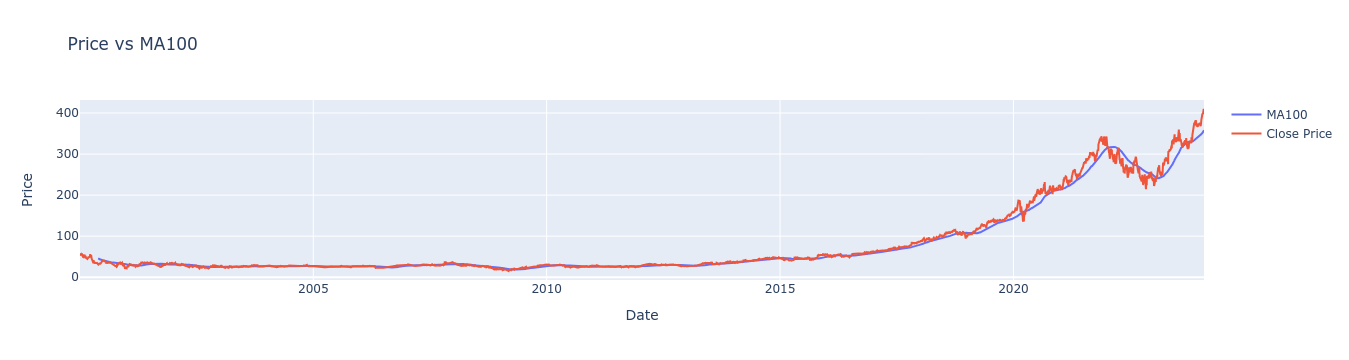

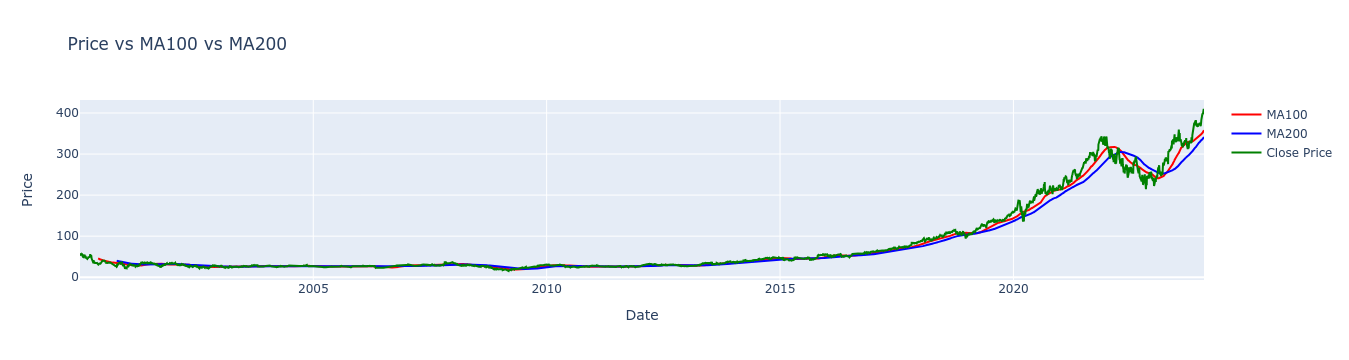

In [17]:
# The 100-day moving average is calculated by summing the past 100 days ClosePx and dividing the result by 100.
# returns a series
ma_100_days = data.Close.rolling(100).mean()

# Plot
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=data.index, y=ma_100_days, mode='lines', name='MA100'))
fig1.add_trace(go.Scatter(x=data.index, y=data.Close, mode='lines', name='Close Price'))
fig1.update_layout(title='Price vs MA100', xaxis_title='Date', yaxis_title='Price')
fig1.show()

# The 200-day moving average is calculated by summing the past 200 days ClosePx and dividing the result by 200.
# returns a series
ma_200_days = data.Close.rolling(200).mean()

# Plot
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=data.index, y=ma_100_days, mode='lines', name='MA100', line=dict(color='red')))
fig2.add_trace(go.Scatter(x=data.index, y=ma_200_days, mode='lines', name='MA200', line=dict(color='blue')))
fig2.add_trace(go.Scatter(x=data.index, y=data.Close, mode='lines', name='Close Price', line=dict(color='green')))
fig2.update_layout(title='Price vs MA100 vs MA200', xaxis_title='Date', yaxis_title='Price')
fig2.show()

In [18]:
# Drop NANs
data.dropna(inplace=True)

# takes 80% of the ClosePx for data_train (training)
# takes the remaining 20% of the ClosePx for data_test (testing)
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

# Normalization technique
# all features will be transformed into the range [0,1] 
# meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

# fit transforms the data
data_train_scale = scaler.fit_transform(data_train)

x_train = []
y_train = []

# print(data_train_scale.shape) => (4846, 1)

# This creates a sliding window 1 step at a time
# Loop through the range starting from 100 up to the total number of rows in the dataset `data_train_scale`
# Start at 101, grab the first 100 (ClosePx's) and append to x_train then put the 101st into y_train
for i in range(100, data_train_scale.shape[0]):
    # Creating the input sequence for the model- data_train_scale[i-100:i, 0] represents these 100 data points
    x_train.append(data_train_scale[i-100:i, 0])
    # Creating the target value for the model
    y_train.append(data_train_scale[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
x_train

array([[0.41050014, 0.39176263, 0.39741363, ..., 0.16126154, 0.15650281,
        0.1678048 ],
       [0.39176263, 0.39741363, 0.37927096, ..., 0.15650281, 0.1678048 ,
        0.14847245],
       [0.39741363, 0.37927096, 0.38611164, ..., 0.1678048 , 0.14847245,
        0.14817503],
       ...,
       [0.92138572, 0.91938706, 0.89863899, ..., 0.988579  , 0.99019702,
        0.99762063],
       [0.91938706, 0.89863899, 0.87294186, ..., 0.99019702, 0.99762063,
        0.99181497],
       [0.89863899, 0.87294186, 0.87360808, ..., 0.99762063, 0.99181497,
        0.99685922]])

In [20]:
y_train

array([0.14847245, 0.14817503, 0.15739507, ..., 0.99181497, 0.99685922,
       0.99723993])

In [21]:
'''
Linear Regression work here
'''

linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

joblib.dump(linear_model, 'linear_regression_model.h5')

# Load the model
linear_model = joblib.load('linear_regression_model.h5')

In [22]:
# Setting up x_test and y_test

x_test = []
y_test = []

# Need to grab the last 100 days from data_train cuz it will be used to "predict" or compare on the first element of the data_test array
# Remember that I need 100 previous ClosePx in order to predict the ClosePx of any given day in the future
pas_100_days = data_train.tail(100)

print(data_test)

# Combine both arrays into data_test
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

print(pas_100_days)
print(data_test)

data_test_scale  =  scaler.fit_transform(data_test)

                 Close
Date                  
2019-04-09  119.279999
2019-04-10  120.190002
2019-04-11  120.330002
2019-04-12  120.949997
2019-04-15  121.050003
...                ...
2024-01-25  404.869995
2024-01-26  403.929993
2024-01-29  409.720001
2024-01-30  408.589996
2024-01-31  397.579987

[1212 rows x 1 columns]
                 Close
Date                  
2018-11-12  106.870003
2018-11-13  106.940002
2018-11-14  104.970001
2018-11-15  107.279999
2018-11-16  108.290001
...                ...
2019-04-02  119.190002
2019-04-03  119.970001
2019-04-04  119.360001
2019-04-05  119.889999
2019-04-08  119.930000

[100 rows x 1 columns]
           Close
0     106.870003
1     106.940002
2     104.970001
3     107.279999
4     108.290001
...          ...
1307  404.869995
1308  403.929993
1309  409.720001
1310  408.589996
1311  397.579987

[1312 rows x 1 columns]


In [18]:
# This creates a sliding window 1 step at a time
# Loop through the range starting from 100 up to the total number of rows in the dataset `data_train_scale`
# Start at 101, grab the first 100 (ClosePx's) and append to x_train then put the 101st into y_train
for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i, 0])
    y_test.append(data_test_scale[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [18]:
y_predict = linear_model.predict(x_test.reshape(x_test.shape[0], -1))

y_predict = y_predict.reshape(-1, 1)
y_predict = scaler.inverse_transform(y_predict)
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

[*********************100%%**********************]  1 of 1 completed


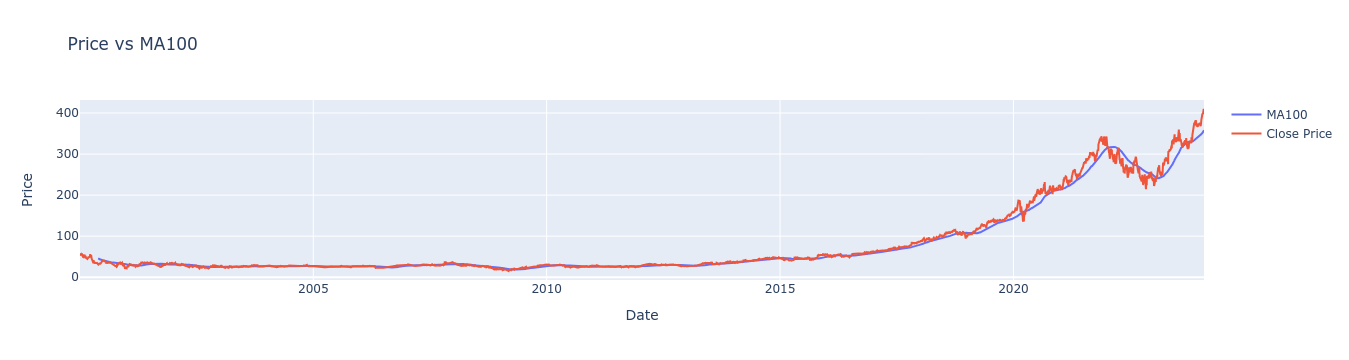

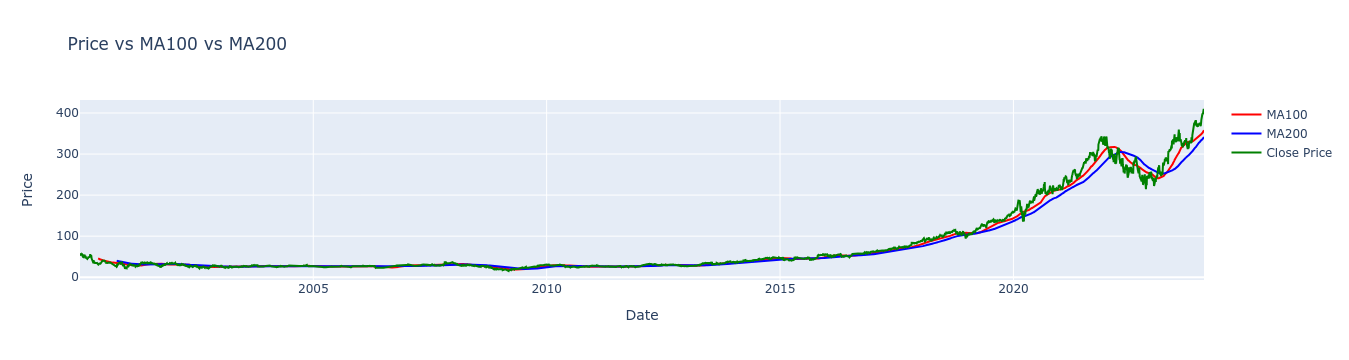

Mean Absolute Error (MAE): 3.350562691096699
Mean Squared Error (MSE): 21.146070425760392


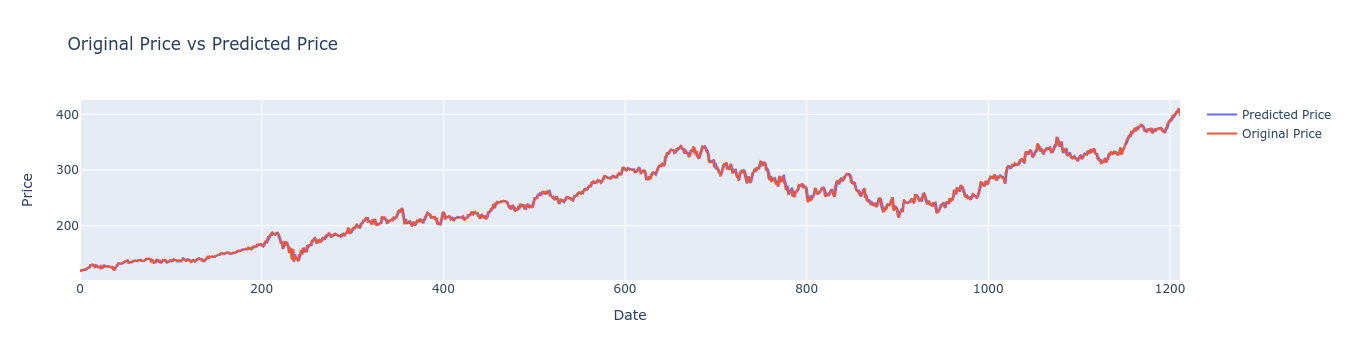

In [18]:
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=data_test.index, y=y_predict.flatten(), mode='lines', name='Predicted Price'))
fig3.add_trace(go.Scatter(x=data_test.index, y=y_test.flatten(), mode='lines', name='Original Price'))
fig3.update_layout(title='Original Price vs Predicted Price', xaxis_title='Date', yaxis_title='Price')
fig3.show()

In [ ]:
#save the file as .keras

[*********************100%%**********************]  1 of 1 completed


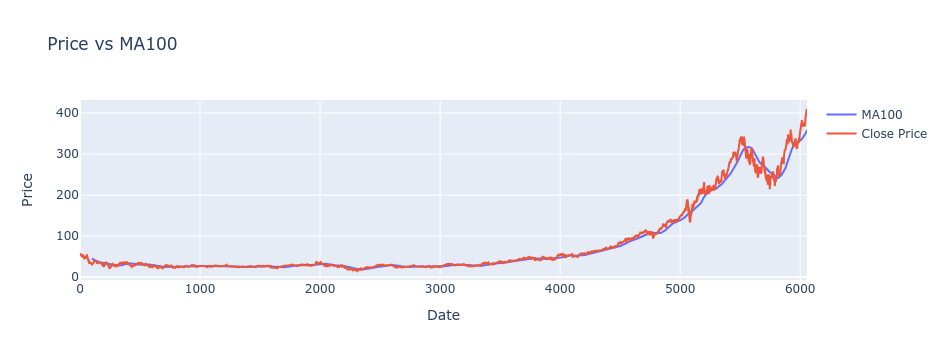

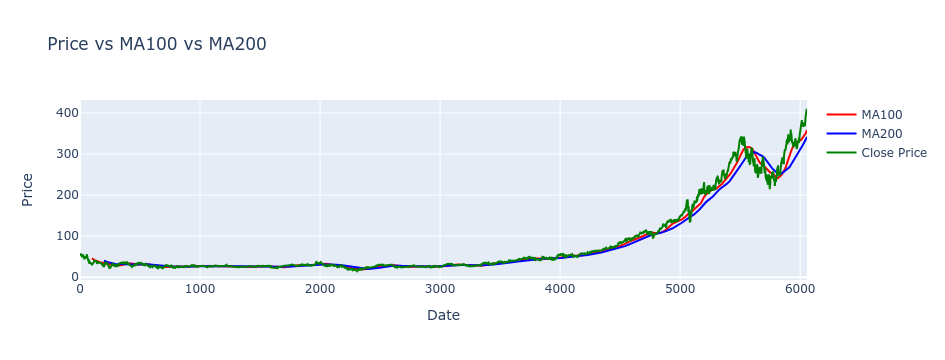

Mean Absolute Error (MAE): 3.350562691096699
Mean Squared Error (MSE): 21.146070425760392


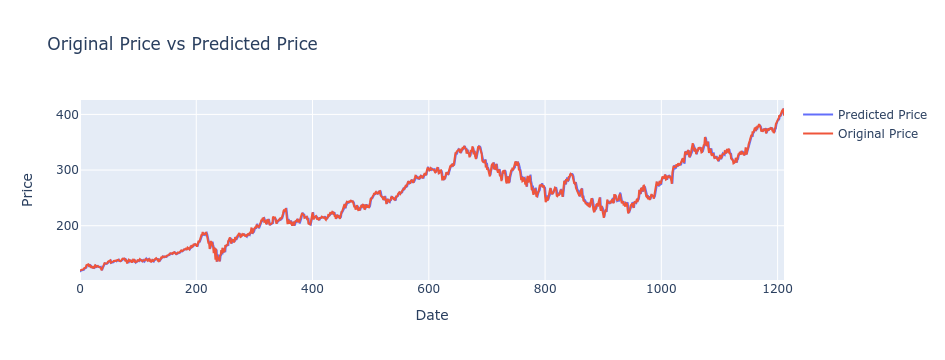

/mnt/sdb1/2ndHome/anaconda3/envs/kaggle/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [19]:
!pip install yfinance plotly tensorflow

import numpy as np
import pandas as pd
import plotly.graph_objs as go
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib

start = '2000-01-01'
end = '2024-02-01'
stock = 'MSFT'

data = yf.download(stock, start, end)

data.reset_index(inplace=True)

ma_100_days = data.Close.rolling(100).mean()

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=data.index, y=ma_100_days, mode='lines', name='MA100'))
fig1.add_trace(go.Scatter(x=data.index, y=data.Close, mode='lines', name='Close Price'))
fig1.update_layout(title='Price vs MA100', xaxis_title='Date', yaxis_title='Price')
fig1.show()

ma_200_days = data.Close.rolling(200).mean()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=data.index, y=ma_100_days, mode='lines', name='MA100', line=dict(color='red')))
fig2.add_trace(go.Scatter(x=data.index, y=ma_200_days, mode='lines', name='MA200', line=dict(color='blue')))
fig2.add_trace(go.Scatter(x=data.index, y=data.Close, mode='lines', name='Close Price', line=dict(color='green')))
fig2.update_layout(title='Price vs MA100 vs MA200', xaxis_title='Date', yaxis_title='Price')
fig2.show()

data.dropna(inplace=True)

data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

scaler = MinMaxScaler(feature_range=(0,1))

data_train_scale = scaler.fit_transform(data_train)

x_train = []
y_train = []

for i in range(100, data_train_scale.shape[0]):
    x_train.append(data_train_scale[i-100:i, 0])
    y_train.append(data_train_scale[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

joblib.dump(linear_model, 'linear_regression_model.h5')

# Load the model
# linear_model = joblib.load('linear_regression_model.h5')

x_test = []
y_test = []

pas_100_days = data_train.tail(100)

data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

data_test_scale  =  scaler.fit_transform(data_test)

for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i, 0])
    y_test.append(data_test_scale[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

y_predict = linear_model.predict(x_test.reshape(x_test.shape[0], -1))

y_predict = y_predict.reshape(-1, 1)
y_predict = scaler.inverse_transform(y_predict)
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=data_test.index, y=y_predict.flatten(), mode='lines', name='Predicted Price'))
fig3.add_trace(go.Scatter(x=data_test.index, y=y_test.flatten(), mode='lines', name='Original Price'))
fig3.update_layout(title='Original Price vs Predicted Price', xaxis_title='Date', yaxis_title='Price')
fig3.show()

# Saving the model as .keras
model = Sequential()
model.add(Dense(1, input_dim=100))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
model.save('linear_regression_model.keras')
